In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install keras-vggface 

In [5]:
!pip install scikit-learn

  Using cached threadpoolctl-2.2.0-py3-none-any.whl (12 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)


In [7]:
!pip install pandas

  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)


In [9]:
!pip install opencv-python

In [12]:
!pip install tqdm

In [2]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [3]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

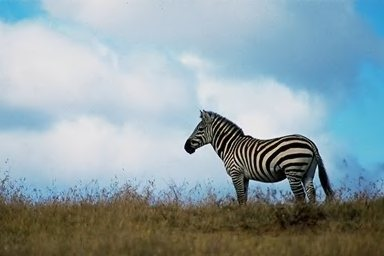

In [5]:
real_image_path = 'D:\CASIA2.0_revised\CASIA2.0_revised\Au\Au_ani_00001.jpg'
Image.open(real_image_path)

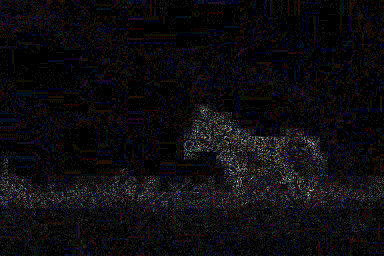

In [6]:
convert_to_ela_image(real_image_path, 90)

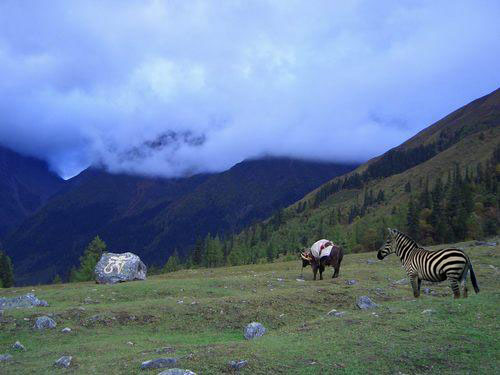

In [7]:
fake_image_path = 'D:\CASIA2.0_revised\CASIA2.0_revised\Tp\Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
Image.open(fake_image_path)

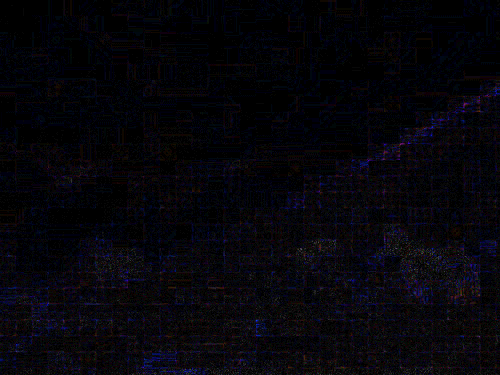

In [8]:
convert_to_ela_image(fake_image_path, 90)

In [9]:
image_size = (128, 128)

In [10]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [11]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [12]:
import random
path = 'D:/CASIA2.0_revised/CASIA2.0_revised/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images


C:\Users\HP\anaconda3\envs\stegproj\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  "Possibly corrupt EXIF data.  "
C:\Users\HP\anaconda3\envs\stegproj\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  "Possibly corrupt EXIF data.  "


Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [13]:
path = 'D:/CASIA2.0_revised/CASIA2.0_revised/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [14]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [16]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [17]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [19]:
epochs = 30
batch_size = 32

In [20]:
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs)
#optimizer =keras.optimizers.Adam(learning_rate = init_lr, decay = init_lr/epochs)

In [21]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [25]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 [==============================] - 89s 851ms/step - loss: 0.5295 - accuracy: 0.7421 - val_loss: 0.3322 - val_accuracy: 0.8908
Epoch 2/30
105/105 [==============================] - 92s 879ms/step - loss: 0.3528 - accuracy: 0.8742 - val_loss: 0.2927 - val_accuracy: 0.8956
Epoch 3/30
105/105 [==============================] - 91s 869ms/step - loss: 0.2980 - accuracy: 0.8922 - val_loss: 0.2756 - val_accuracy: 0.9016
Epoch 4/30
105/105 [==============================] - 88s 834ms/step - loss: 0.2619 - accuracy: 0.9048 - val_loss: 0.2551 - val_accuracy: 0.9100
Epoch 5/30
105/105 [==============================] - 86s 816ms/step - loss: 0.2206 - accuracy: 0.9225 - val_loss: 0.2242 - val_accuracy: 0.9196
Epoch 6/30
105/105 [==============================] - 87s 829ms/step - loss: 0.1919 - accuracy: 0.9292 - val_loss: 0.2106 - val_accuracy: 0.9124
Epoch 7/30
105/105 [==============================] - 93s 883ms/step - loss: 0.1687 - accuracy: 0.9349 - val_loss: 0.2078 - val_ac

In [26]:
model.save('model_casia_run1.h5')

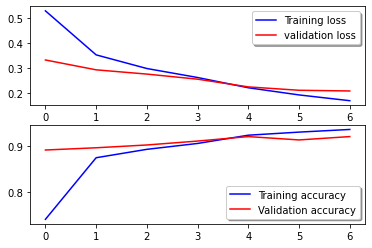

In [27]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.01181507 0.9881849 ]
 [0.00203645 0.99796355]
 [0.9893644  0.01063559]
 ...
 [0.86030704 0.1396929 ]
 [0.87427104 0.1257289 ]
 [0.00739939 0.9926006 ]]


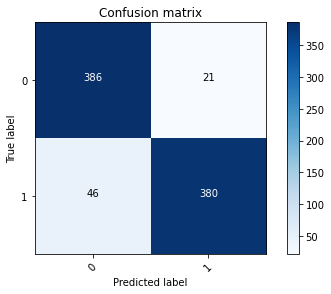

In [29]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
print(Y_pred)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [18]:
class_names = ['fake', 'real']

In [19]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 50.59


In [20]:
fake_image = os.listdir('D:/CASIA2.0_revised/CASIA2.0_revised/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('D:/CASIA2.0_revised/CASIA2.0_revised/Tp', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

KeyboardInterrupt: 

In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

In [34]:
real_image = os.listdir('D:/CASIA2.0_revised/CASIA2.0_revised/Au')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('D:/CASIA2.0_revised/CASIA2.0_revised/Au', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
           # print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [35]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7437, Correct: 6651, Acc: 89.43122226704317
Total: 9501, Correct: 8671, Acc: 91.26407746552995


In [36]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Tp_D_NNN_M_N_nat10156_ani00021_12020.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 81.05


In [37]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/kkk.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')


Class: fake Confidence: 64.94


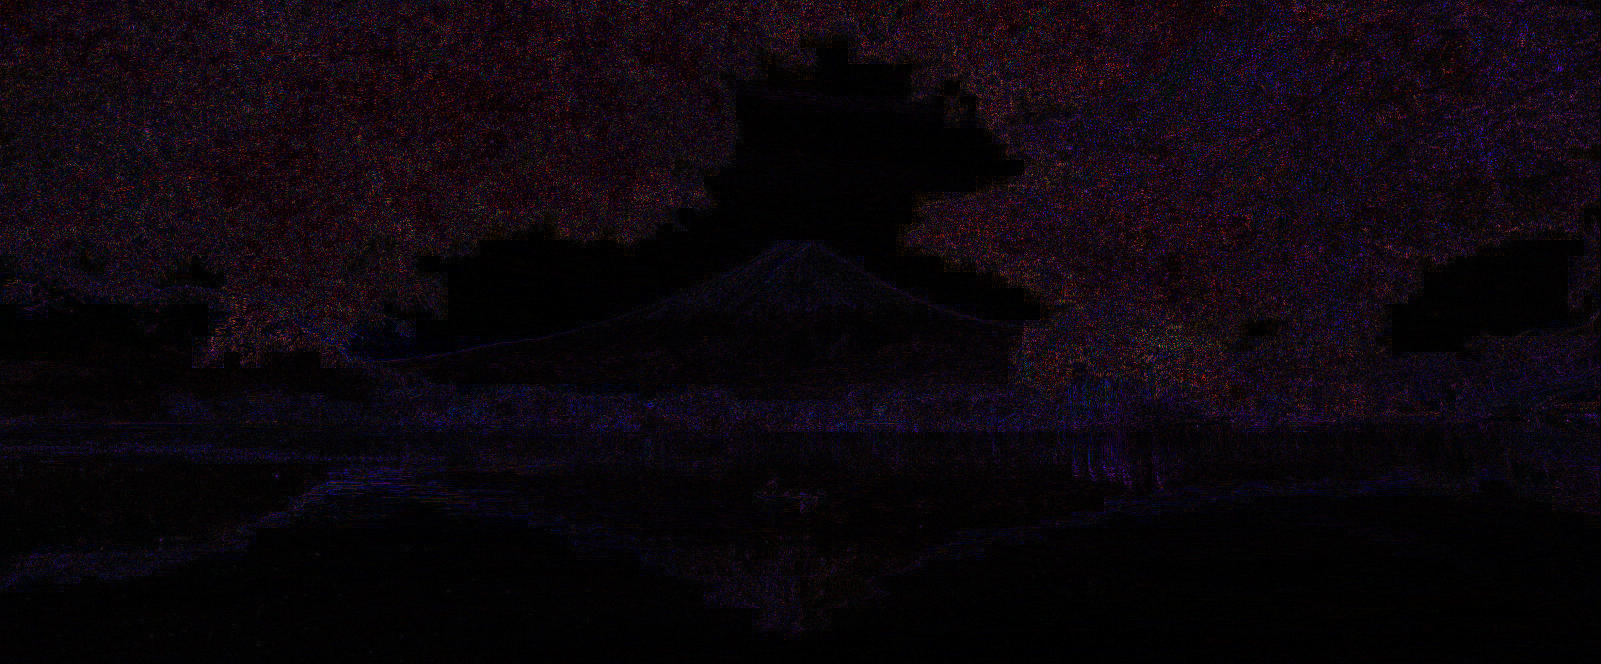

In [38]:
convert_to_ela_image(real_image_path, 90)

In [39]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/lk.jfif'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')


Class: fake Confidence: 72.59


In [53]:
#Handwritten image

real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/ddd.jfif'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 100.00


In [54]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/UN-AMI-POUR-TOUS.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 64.61


In [50]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/filter_matrix.png'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 96.14


In [45]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Polar_Bear_-_Alaska_(cropped).jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 83.83


In [56]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/1200px-Eopsaltria_australis_-_Mogo_Campground.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 80.61


In [57]:
import pickle

In [43]:
#with open('model_pickle','wb') as f:
 #   pickle.dump(model,f)

In [50]:
!pip install joblib

In [39]:
#from sklearn.externals import joblib

In [69]:
import joblib

In [40]:
#joblib.dump(model,'model_joblib')

In [58]:
img_pkl=open("mod_pkl.pkl","wb")

In [41]:
#img_pkl=open(mod_pkl.pkl.read)

In [42]:
#pickle.dump(model,img_pkl)

In [60]:
img_pkl.close()

In [66]:
import os
import types
import tempfile
import keras.models

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self._dict_ = model._dict_


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

make_keras_picklable()

In [67]:
img_pkl=open("mod_pkl.pkl","wb")

In [78]:
#pickle.dump(model,img_pkl)

In [71]:
import tempfile
import tensorflow as tf

class PicklableKerasModel(tf.keras.models.Model):

    def __init__(self, model):
        self._model = model

    def __getstate__(self):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            tf.keras.models.save_model(self._model, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = tf.keras.models.load_model(fd.name)
        self._model = model

    def __getattr__(self, name):
        return getattr(self.__dict__['_model'], name)

    def __setattr__(self, name, value):
        if name == '_model':
            self.__dict__['_model'] = value
        else:
            setattr(self.__dict__['_model'], name, value)

    def __delattr__(self, name):
        delattr(self.__dict__['_model'], name)

In [72]:
model = Sequential() # etc etc

picklable_model = PicklableKerasModel(model)

In [73]:
img_pkl=open("mod_pkl.pkl","wb")

In [77]:
#pickle.dump(model,img_pkl)

In [ ]:
                                        #CREATING NEW MODEL AND LOADING TRAINED MODEL INTO IT.

In [2]:
import os

import tensorflow as tf
from tensorflow import keras

In [3]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('model_casia_run1.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [4]:
#loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

In [5]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [8]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [9]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Polar_Bear_-_Alaska_(cropped).jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 95.62


In [29]:
class_names = ['fake', 'real']
real_image_path = 'D:/tiny-imagenet-200/outnew/images/val_0.jpeg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 82.27


In [13]:
class_names = ['fake', 'real']
real_image_path = 'D:/tiny-imagenet-200/outnew/images/val_12.jpeg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

FileNotFoundError: [Errno 2] No such file or directory: 'D:/tiny-imagenet-200/outnew/images/val_12.jpeg'

In [30]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/lk.jfif'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

FileNotFoundError: [Errno 2] No such file or directory: 'D:/CASIA2.0_revised/CASIA2.0_revised/test/lk.jfif'

In [31]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Tp_D_NNN_M_N_cha10166_nat10156_12272.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

FileNotFoundError: [Errno 2] No such file or directory: 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Tp_D_NNN_M_N_cha10166_nat10156_12272.jpg'

In [22]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Tp_D_NNN_M_N_nat10156_ani00021_12020.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 71.30


In [23]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Au_nat_10156.bmp'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 64.69


In [30]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Au_art_00028.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 94.31


In [34]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Au_nat_00095.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 99.95


In [35]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Au_art_00028.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 94.31


In [36]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Au_sec_00042.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 97.94


In [10]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Au_nat_00008.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 98.44


In [11]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

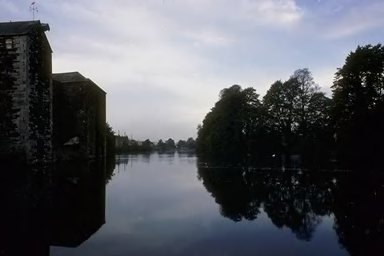

In [17]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Au_nat_00008.jpg'
Image.open(real_image_path)

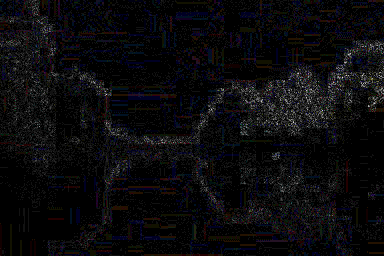

In [13]:
convert_to_ela_image(real_image_path, 90)

In [14]:
class_names = ['fake', 'real']
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Tp_D_CRN_M_N_nat00008_art00025_11425.jpg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 91.71


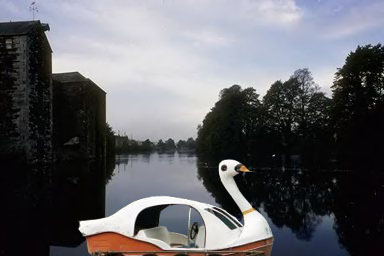

In [15]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Tp_D_CRN_M_N_nat00008_art00025_11425.jpg'
Image.open(real_image_path)

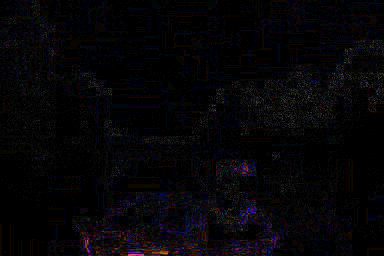

In [16]:
convert_to_ela_image(real_image_path, 90)

In [19]:

class_names = ['fake', 'real']
real_image_path = 'D:/tiny-imagenet-200/latest/images/val_4.jpeg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 96.12


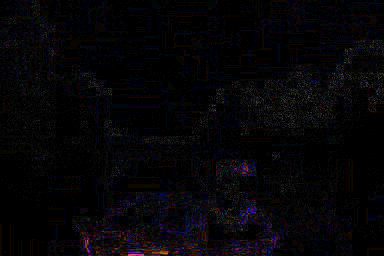

In [20]:
real_image_path = 'D:/CASIA2.0_revised/CASIA2.0_revised/test/Tp_D_CRN_M_N_nat00008_art00025_11425.jpg'
Image.open(real_image_path)
convert_to_ela_image(real_image_path, 90)

In [21]:
class_names = ['fake', 'real']
real_image_path = 'D:/tiny-imagenet-200/latest/images/val_19.jpeg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 99.92


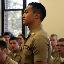

In [22]:
real_image_path = 'D:/tiny-imagenet-200/latest/images/val_19.jpeg'
Image.open(real_image_path)

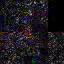

In [23]:
convert_to_ela_image(real_image_path, 90)

In [39]:
class_names = ['fake', 'real']
real_image_path = 'D:/tiny-imagenet-200/latest/images/val_4.jpeg'
Image.open(real_image_path)
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 96.12


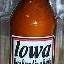

In [40]:
real_image_path = 'D:/tiny-imagenet-200/latest/images/val_7.jpeg'
Image.open(real_image_path)

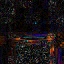

In [38]:
convert_to_ela_image(real_image_path, 90)